# Client Comparison
In this notebook, we will attempt to compare the performance of the different eth2 clients participating in the Medalla testnet. These clients are:
- [Prysm](https://github.com/prysmaticlabs/prysm) from [Prysmatic Labs](https://prysmaticlabs.com/)
- [Lighthouse](https://github.com/sigp/lighthouse) from [Sigma Prime](https://sigmaprime.io/)
- [Teku](https://github.com/PegaSysEng/teku) from [PegaSys](https://pegasys.tech/)
- [Nimbus](https://github.com/status-im/nimbus) from [Status.im](https://status.im/)
- [Lodestar](https://github.com/ChainSafe/lodestar) from [Chainsafe](https://chainsafe.io/)

There is no definitive way to identify which client software powers each validator — as long as the client follows the protocol rules, any number of different implementations could exist. However, for the purposes of Medalla, many users chose to indicate what client they were using in the `graffiti` field in blocks they propose. Those aiming to collect [POAP non-fungible tokens (NFTs)](https://beaconcha.in/poap) will have set their validators to include a graffiti string indicating their eth1 deposit address, and ending with a letter A, B, C, D or E, corresponding to the Prysm, Lighthouse, Teku, Nimbus and Lodestar clients respectively. For example, the third block in the dataset has the graffiti `poapg4eM7/cwRi/ZhaZg0zp6b9A6JlcA` indicating the block was produced by the Prysm client. Other validators have included the full name of their client in the graffiti — for example the very next block includes the graffiti `Lighthouse/v0.2.0/f26adc0a`. It seems a reasonable guess that this block was produced by the Lighthouse client.

Of course, the graffiti field can be set to whatever the user running the validator chooses. There seems to be little reason to expect users would not be honest, with the exception that some may have chosen to game the POAP system to collect NTFs for all clients without the hassle of actually installing and using them. Nonetheless, to make progress with our analysis we will need to assume that the majority of validators were honest. Where we have large numbers of validators indicating the use of a certain client therefore, we can probably expect to a reasonable view of how that client has performed in aggregate. We may need to be a little more cautious if there are clients with a very small number of validators indicating participation through their beacon chain graffiti.

For the purposes of this analysis, we will assume that any validator which consistently indicates a particular client through its graffiti is genuinely running the claimed client. Validators which appear to switch clients, or which refer to mulitple clients in their graffiti, will be excluded.

NB This will exclude even users who genuinely have switched clients, since validators produce blocks only occasionally, and it would be impossible to know exactly when they switched.

In [1]:
# imports
import psycopg2
import math
import time
import matplotlib.pyplot as plt
import pandas as pd

from chaindtools import *

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

First, we restore some variables saved in the previous notebook to save recalculating them.

In [3]:
%store -r validators n_epochs latest_slot

## Client proportions
It turns out that the majority of validators (71%) did not provide information in block graffiti which could be used to identify the client used. This includes all validators which did not propose any blocks, since graffiti is only supplied by the block producer each block. For this reason, validators who were *absent* or those which did not participate long enough to propose any blocks, are excluded.

Number of validators: 67291
 9081 Prysm validators (13.5%)
 5714 Lighthouse validators (8.5%)
 1812 Teku validators (2.7%)
 1354 Nimbus validators (2.0%)
   34 Lodestar validators (0.1%)
 1633 ambiguous (2.4%)
47663 no info (70.8%)


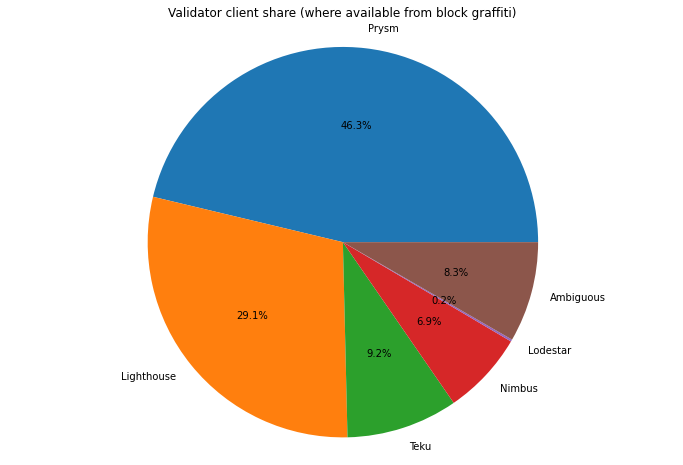

In [4]:
# determine validator clients from block graffiti

cursor.execute(f"SELECT f_proposer_index, f_graffiti FROM t_blocks")
proposers = cursor.fetchall()

for _, validator in validators.items():
    validator["client"] = ""

for proposer in proposers:
    validator_index = proposer[0]
    graffiti = proposer[1].tobytes().decode(errors='ignore').lower()
    if validators[validator_index]["client"] == "ambiguous":
        continue
    A_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "a") or graffiti.find("prysm") != -1 else 0
    B_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "b") or graffiti.find("lighthouse") != -1 else 0
    C_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "c") or graffiti.find("teku") != -1 else 0
    D_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "d") or graffiti.find("nimbus") != -1 else 0
    E_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "e") or graffiti.find("lodestar") != -1 else 0
    n_flags = A_flag + B_flag + C_flag + D_flag + E_flag

    if n_flags > 1:
        validators[validator_index]["client"] = "ambiguous"
    elif A_flag:
        if validators[validator_index]["client"] == "" or validators[validator_index]["client"] == "prysm":
            validators[validator_index]["client"] = "prysm"
        else:
            validators[validator_index]["client"] = "ambiguous"
    elif B_flag:
        if validators[validator_index]["client"] == "" or validators[validator_index]["client"] == "lighthouse":
            validators[validator_index]["client"] = "lighthouse"
        else:
            validators[validator_index]["client"] = "ambiguous"
    elif C_flag:
        if validators[validator_index]["client"] == "" or validators[validator_index]["client"] == "teku":
            validators[validator_index]["client"] = "teku"
        else:
            validators[validator_index]["client"] = "ambiguous"
    elif D_flag:
        if validators[validator_index]["client"] == "" or validators[validator_index]["client"] == "nimbus":
            validators[validator_index]["client"] = "nimbus"
        else:
            validators[validator_index]["client"] = "ambiguous"
    elif E_flag:
        if validators[validator_index]["client"] == "" or validators[validator_index]["client"] == "lodestar":
            validators[validator_index]["client"] = "lodestar"
        else:
            validators[validator_index]["client"] = "ambiguous"

A_count = B_count = C_count = D_count = E_count = amb_count = 0
for _, validator in validators.items():
    if validator["client"] == "prysm":
        A_count += 1
    elif validator["client"] == "lighthouse":
        B_count += 1
    elif validator["client"] == "teku":
        C_count += 1
    elif validator["client"] == "nimbus":
        D_count += 1
    elif validator["client"] == "lodestar":
        E_count += 1
    elif validator["client"] == "ambiguous":
        amb_count += 1

none_count = len(validators) - A_count - B_count - C_count - D_count - E_count - amb_count 
print(f"Number of validators: {len(validators)}")
print(f"{A_count:5} Prysm validators ({100*A_count/len(validators):.1f}%)")
print(f"{B_count:5} Lighthouse validators ({100*B_count/len(validators):.1f}%)")
print(f"{C_count:5} Teku validators ({100*C_count/len(validators):.1f}%)")
print(f"{D_count:5} Nimbus validators ({100*D_count/len(validators):.1f}%)")
print(f"{E_count:5} Lodestar validators ({100*E_count/len(validators):.1f}%)")
print(f"{amb_count:5} ambiguous ({100*amb_count/len(validators):.1f}%)")
print(f"{none_count:5} no info ({100*none_count/len(validators):.1f}%)")

labels = ['Prysm', 'Lighthouse', 'Teku', 'Nimbus', 'Lodestar', 'ambiguous']
clients = [A_count, B_count, C_count, D_count, E_count, amb_count]

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.pie(clients, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Validator client share (where available from block graffiti)')
plt.show()

In [5]:
# run through attestations: calculate participation rates and mean inclusion distance for each client
# if the attestation is missed and the validator has not yet done any attestations, it is considered dormant
# if the attestation is missed and there are no future attestations, it is considered abandoned

start_time = time.time()

empty = [0] * n_epochs
clients = ["prysm", "lighthouse", "teku", "nimbus"]
success_count   = {client:empty.copy() for client in clients}
absent_count    = {client:empty.copy() for client in clients}
dormant_count   = {client:empty.copy() for client in clients}
abandoned_count = {client:empty.copy() for client in clients}
missed_count    = {client:empty.copy() for client in clients}
sum_distance    = {client:empty.copy() for client in clients}


for slot in range(latest_slot+1):
    validator_scores = attestation_performance(cursor, slot)
    epoch = slot // 32
    for validator_index in validator_scores:
        client = validators[validator_index]["client"]
        if client not in clients:
            continue
        if validator_scores[validator_index] != -1:
            success_count[client][epoch]   += 1
            sum_distance[client][epoch]    += validator_scores[validator_index]
        elif validators[validator_index]["latest_attestation"] == -1:
            absent_count[client][epoch]    += 1
        elif slot < validators[validator_index]["first_attestation"]:
            dormant_count[client][epoch]   += 1
        elif slot > validators[validator_index]["latest_attestation"]:
            abandoned_count[client][epoch] += 1
        else:
            missed_count[client][epoch]    += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
    percentage = 100*(slot+1)/(latest_slot+1)
    print(f"Epoch {epoch} of {latest_slot//32} ({percentage:.2f}%). "
          f"{elapsed} elapsed. {left} left.", end='\r')


mean_inclusion_distance = {}
for client in clients:
    mean_inclusion_distance[client] = [sum_distance[client][e] / success_count[client][e] 
                                       if success_count[client][e] > 0 else None for e in range(n_epochs)]
    
print(f"Pass completed in {elapsed}." + ' ' * 50)

Pass completed in 00:17:50.                                                  


## Participation Rate
Let's have a look at how the participation rates for the different clients compare. As in the previous notebook, we're going to ignore *dormant* and *abandoned* validators. As mentioned above, *absent* validators are already excluded from this dataset. Also, given the very low number of validators self-identifying as Lodestar, this client will be excluded from the remaining analysis, since any results from such a small sample would be unreliable,

             prysm   lighthouse         teku       nimbus
count  9835.000000  9835.000000  9835.000000  9835.000000
mean      0.851676     0.688506     0.835621     0.407712
std       0.262325     0.276935     0.256277     0.307624
min       0.000000     0.000000     0.000000     0.000000
25%       0.902336     0.481862     0.880282     0.155268
50%       0.936910     0.792136     0.917028     0.354642
75%       0.975239     0.926080     0.949727     0.673607
max       1.000000     1.000000     1.000000     1.000000


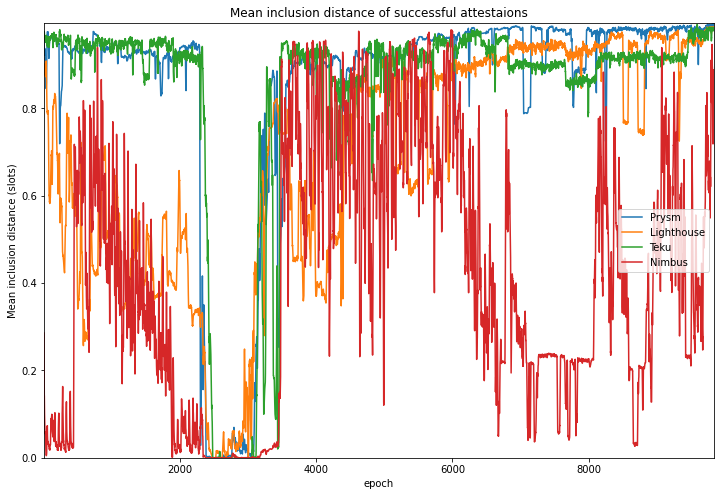

             prysm   lighthouse         teku       nimbus
count  4835.000000  4835.000000  4835.000000  4835.000000
mean      0.958696     0.898502     0.918877     0.464606
std       0.045694     0.090184     0.045509     0.270902
min       0.720186     0.548817     0.177443     0.023503
25%       0.958388     0.886501     0.895865     0.227376
50%       0.975392     0.926853     0.916769     0.417424
75%       0.984087     0.955408     0.944667     0.700151
max       1.000000     1.000000     1.000000     1.000000


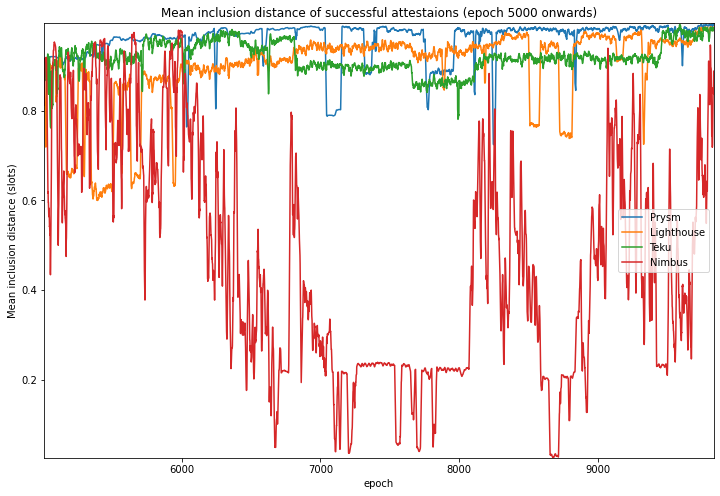

In [6]:
# calculate/describe/plot participation rates by client
participation_rate = {}
for client in clients:
    participation_rate[client] = [success_count[client][e] /
                                  (success_count[client][e] + missed_count[client][e]) for e in range(n_epochs)]

participation_rate_df = pd.DataFrame(participation_rate)

print(participation_rate_df.describe())

# plot the participation rate
fig=plt.figure(figsize=(12,8))
plt.plot(participation_rate_df['prysm'].rolling(10).mean(), label='Prysm')
plt.plot(participation_rate_df['lighthouse'].rolling(10).mean(), label='Lighthouse')
plt.plot(participation_rate_df['teku'].rolling(10).mean(), label='Teku')
plt.plot(participation_rate_df['nimbus'].rolling(10).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

print(participation_rate_df.iloc[5000:].describe())

# plot the participation rate
fig=plt.figure(figsize=(12,8))
plt.plot(participation_rate_df['prysm'].iloc[5000:].rolling(10).mean(), label='Prysm')
plt.plot(participation_rate_df['lighthouse'].iloc[5000:].rolling(10).mean(), label='Lighthouse')
plt.plot(participation_rate_df['teku'].iloc[5000:].rolling(10).mean(), label='Teku')
plt.plot(participation_rate_df['nimbus'].iloc[5000:].rolling(10).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

## Mean Inclusion Distance
Let's repeat the plot of mean inclusion distance we previously saw for the network as a whole, this time, broken down by client.

Mean inclusion distance statistics

             prysm   lighthouse         teku       nimbus
count  9716.000000  9743.000000  9336.000000  9115.000000
mean      1.356927     1.391406     1.027837     0.944636
std       3.447063     3.571424     2.304084     1.667262
min       0.033238     0.005305     0.001385     0.000000
25%       0.282152     0.253826     0.306306     0.340409
50%       0.399438     0.369034     0.516623     0.540079
75%       0.587399     0.572595     0.863896     0.970967
max      29.000000    31.000000    31.000000    31.000000



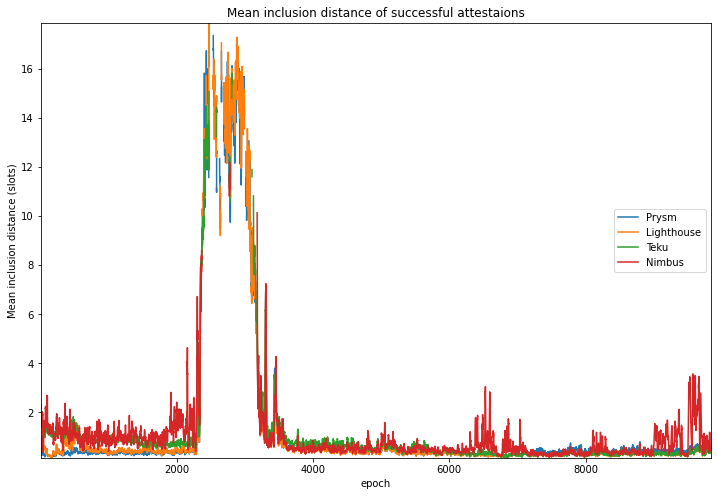

Mean inclusion distance statistics

             prysm   lighthouse         teku       nimbus
count  4835.000000  4835.000000  4835.000000  4835.000000
mean      0.400729     0.325728     0.363114     0.608320
std       0.198241     0.180290     0.206437     0.654504
min       0.035857     0.005305     0.001385     0.034364
25%       0.265381     0.207871     0.224401     0.276941
50%       0.368455     0.289501     0.318182     0.414729
75%       0.492691     0.400540     0.445836     0.644232
max       2.827844     2.726548     2.385857     9.868132



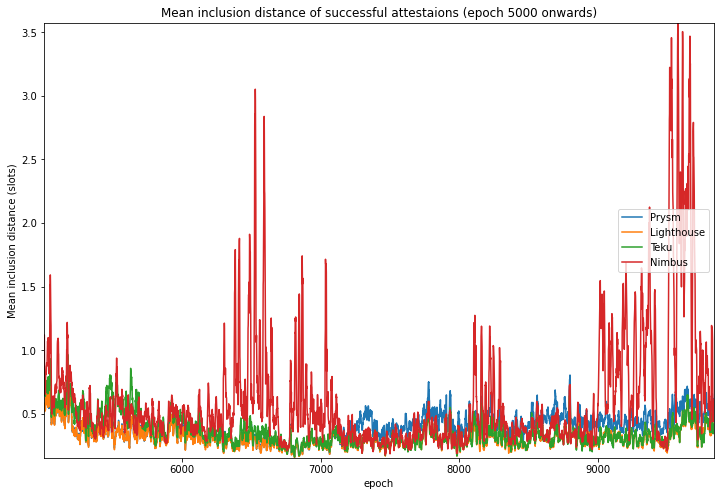

In [7]:
# graphs and stats for mean inclusion distance
mid_df = pd.DataFrame.from_dict(mean_inclusion_distance)

print("Mean inclusion distance statistics\n")
print(mid_df.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(mid_df['prysm'].rolling(10).mean(), label='Prysm')
plt.plot(mid_df['lighthouse'].rolling(10).mean(), label='Lighthouse')
plt.plot(mid_df['teku'].rolling(10).mean(), label='Teku')
plt.plot(mid_df['nimbus'].rolling(10).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

print("Mean inclusion distance statistics\n")
print(mid_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(mid_df['prysm'].iloc[5000:].rolling(10).mean(), label='Prysm')
plt.plot(mid_df['lighthouse'].iloc[5000:].rolling(10).mean(), label='Lighthouse')
plt.plot(mid_df['teku'].iloc[5000:].rolling(10).mean(), label='Teku')
plt.plot(mid_df['nimbus'].iloc[5000:].rolling(10).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()